# Traning - Features

In [11]:
%pip install -r ../requirements.txt

You should consider upgrading via the '/home/rcalabro/codebase/senac-ia/neural-networks/rn-musical-instruments/.venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [12]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'
os.environ['ABSL_LOG_THRESHOLD'] = '0'

# Built-in
import ast
import json
from functools import partial
from pathlib import Path

# Third-party - Data Handling
import numpy as np
import pandas as pd

# Third-party - Visualization
import matplotlib.pyplot as plt

# Third-party - Machine Learning
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

# Third-party - Deep Learning
import keras
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Third-party - Audio Processing
import librosa
from librosa.feature.rhythm import tempo
import soundfile as sf

# Third-party - Utilities
from tqdm import tqdm

print("TensorFlow:", tf.__version__)
print("Keras:", keras.__version__)
print("Is TensorFlow using GPU?", tf.test.is_gpu_available())
print("GPU disponível:", tf.config.list_physical_devices('GPU'))
print("XLA ativado:", tf.config.optimizer.get_jit())
# Mostra configuração geral
tf.config.experimental.list_physical_devices()

TensorFlow: 2.19.0
Keras: 3.9.2
Is TensorFlow using GPU? True
GPU disponível: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
XLA ativado: 


I0000 00:00:1745974155.096466    2463 gpu_device.cc:2019] Created device /device:GPU:0 with 3615 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:0a:00.0, compute capability: 7.5


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [13]:
ORIGIN_DATASET_PATH = '../datasets/augmented'
ORIGIN_DATASET_VERSION = 'v2'

ORIGIN_DATASET_VERSION_PATH = Path(os.path.join(ORIGIN_DATASET_PATH, ORIGIN_DATASET_VERSION))
ORIGIN_DATASET_TRAIN_METADATA = ORIGIN_DATASET_VERSION_PATH / 'train_metadata.csv'
ORIGIN_DATASET_TRAIN_DATA = ORIGIN_DATASET_VERSION_PATH / 'train_data'

ORIGIN_DATASET_TEST_METADATA = ORIGIN_DATASET_VERSION_PATH / 'test_metadata.csv'
ORIGIN_DATASET_TEST_DATA = ORIGIN_DATASET_VERSION_PATH / 'test_data'

In [14]:
TRAINING_DATASET_PATH = '../datasets/training'
TRAINING_DATASET_VERSION = 'v7'

TRAINING_DATASET_VERSION_PATH = Path(os.path.join(TRAINING_DATASET_PATH, TRAINING_DATASET_VERSION))

TRAINING_DATASET_TRAIN_METADATA = TRAINING_DATASET_VERSION_PATH / 'train_metadata.csv'
TRAINING_DATASET_TEST_METADATA = TRAINING_DATASET_VERSION_PATH / 'test_metadata.csv'

TRAINING_DATASET_VERSION_PATH.mkdir(parents=True, exist_ok=True)
print(f"📁 TRAINING_DATASET_VERSION_PATH: {TRAINING_DATASET_VERSION_PATH}")

📁 TRAINING_DATASET_VERSION_PATH: ../datasets/training/v7


In [15]:
def extract_features(row, basepath, n_mfcc=80):
    filepath = basepath / row['filename']
    y, sr = librosa.load(filepath, res_type='kaiser_fast')

    # 🎵 MFCC e Delta
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    delta_mfcc = librosa.feature.delta(mfcc)


    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr)

    combined = np.concatenate((mfcc, delta_mfcc, chroma, contrast), axis=0)

    # 🔄 Normalizar
    combined = (combined - np.mean(combined)) / np.std(combined)

    return combined.T  # shape: (2*n_mfcc,)


In [16]:

def prepare_dataset(metadata_file, output_metadata, input_audio_dir=None, n_mfcc=80):
    metadata_file = Path(metadata_file)
    output_metadata = Path(output_metadata)
    input_audio_dir = Path(input_audio_dir) if input_audio_dir else metadata_file.parent

    df = pd.read_csv(metadata_file)

    label_encoder = LabelEncoder()
    df['label'] = label_encoder.fit_transform(df['class'])

    tqdm.pandas(desc="Extraindo features")
    df['features'] = df.progress_apply(lambda row: extract_features(row, input_audio_dir, n_mfcc).mean(axis=0).tolist(), axis=1)

    df[['class', 'features', 'label']].to_csv(output_metadata, index=False)
    print(f"✅ Dataset com features salvo em: {output_metadata}")
    return label_encoder

In [17]:
# label_encoder = prepare_dataset(
#     metadata_file=ORIGIN_DATASET_TRAIN_METADATA,
#     input_audio_dir=ORIGIN_DATASET_TRAIN_DATA,
#     output_metadata=TRAINING_DATASET_TRAIN_METADATA,
#     n_mfcc=80
# )

In [18]:
def load_dataset_from_csv(csv_path):
    df = pd.read_csv(csv_path)

    df['features'] = df['features'].apply(ast.literal_eval)

    X = np.vstack(df['features'].values).astype(np.float32)

    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(df['class'].values)

    ds_shape = set((X.shape[1],))

    return X, y, label_encoder, ds_shape

# Uso:
X, y, label_encoder, ds_shape = load_dataset_from_csv(TRAINING_DATASET_TRAIN_METADATA)

print(ds_shape)

# 🔥 Split normal
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

{179}


In [19]:
def build_robust_dense_model(input_shape, num_classes, gamma=1.0, alpha=0.25):
    inputs = layers.Input(shape=input_shape)

    x = layers.BatchNormalization()(inputs)

    x = layers.Dense(512, activation='swish', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)

    x1 = layers.Dense(256, activation='swish', kernel_regularizer=regularizers.l2(1e-4))(x)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.Dropout(0.3)(x1)

    x2 = layers.Dense(256, activation='swish', kernel_regularizer=regularizers.l2(1e-4))(x1)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.Dropout(0.3)(x2)

    x = layers.add([x1, x2])

    x3 = layers.Dense(128, activation='swish', kernel_regularizer=regularizers.l2(1e-4))(x)
    x3 = layers.BatchNormalization()(x3)
    x3 = layers.Dropout(0.25)(x3)

    x4 = layers.Dense(128, activation='swish', kernel_regularizer=regularizers.l2(1e-4))(x3)
    x4 = layers.BatchNormalization()(x4)
    x4 = layers.Dropout(0.25)(x4)

    x = layers.add([x3, x4])

    x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs)


    def focal_loss(gamma=2., alpha=0.25):
        def loss(y_true, y_pred):
            y_true = tf.cast(y_true, tf.int32)
            y_true_one_hot = tf.one_hot(y_true, depth=tf.shape(y_pred)[-1])
            cross_entropy = K.categorical_crossentropy(y_true_one_hot, y_pred)
            pt = tf.reduce_sum(y_true_one_hot * y_pred, axis=-1)
            fl = alpha * tf.pow(1. - pt, gamma) * cross_entropy
            return fl
        return loss

    model.compile(
        optimizer='adam',
        loss=focal_loss(gamma=gamma, alpha=alpha),
        metrics=['accuracy']
    )

    return model



In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image, display

model = build_robust_dense_model(
    input_shape=ds_shape,
    num_classes=len(label_encoder.classes_)
)

plot_model(
    model,
    to_file='model_plot.png',
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True,
    dpi=96
)

# Exibe no notebook
display(Image(filename='model_plot.png'))


2025-04-29 21:47:35.497712: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745974055.545286    2463 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745974055.563295    2463 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745974055.643610    2463 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745974055.643675    2463 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745974055.643677    2463 computation_placer.cc:177] computation placer alr

NameError: name 'ds_shape' is not defined

I0000 00:00:1745974195.629417    2463 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3615 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:0a:00.0, compute capability: 7.5


KeyboardInterrupt: 

In [42]:
model = build_robust_dense_model(
    input_shape=(179,),
    num_classes=len(label_encoder.classes_),
    gamma=1.5,
    alpha=0.3,
)

callbacks = [
    EarlyStopping(patience=15, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.5, patience=10, verbose=1)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=128,
    epochs=100,
    callbacks=callbacks
)

Epoch 1/100


I0000 00:00:1745961270.250560  135287 service.cc:152] XLA service 0x7f2740002df0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745961270.250743  135287 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2025-04-29 18:14:30.392645: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745961271.002120  135287 cuda_dnn.cc:529] Loaded cuDNN version 90300


34/99 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3461 - loss: 0.4969

I0000 00:00:1745961276.262788  135287 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


99/99 ━━━━━━━━━━━━━━━━━━━━ 17s 81ms/step - accuracy: 0.4476 - loss: 0.4038 - val_accuracy: 0.4466 - val_loss: 0.3125 - learning_rate: 0.0010
Epoch 2/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6372 - loss: 0.2371 - val_accuracy: 0.5170 - val_loss: 0.2910 - learning_rate: 0.0010
Epoch 3/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6619 - loss: 0.2140 - val_accuracy: 0.5727 - val_loss: 0.2965 - learning_rate: 0.0010
Epoch 4/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6743 - loss: 0.1976 - val_accuracy: 0.6171 - val_loss: 0.2609 - learning_rate: 0.0010
Epoch 5/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6792 - loss: 0.1897 - val_accuracy: 0.6713 - val_loss: 0.1958 - learning_rate: 0.0010
Epoch 6/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6821 - loss: 0.1814 - val_accuracy: 0.6913 - val_loss: 0.1788 - learning_rate: 0.0010
Epoch 7/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6941 - loss: 0.1716 - val_accuracy: 0.6

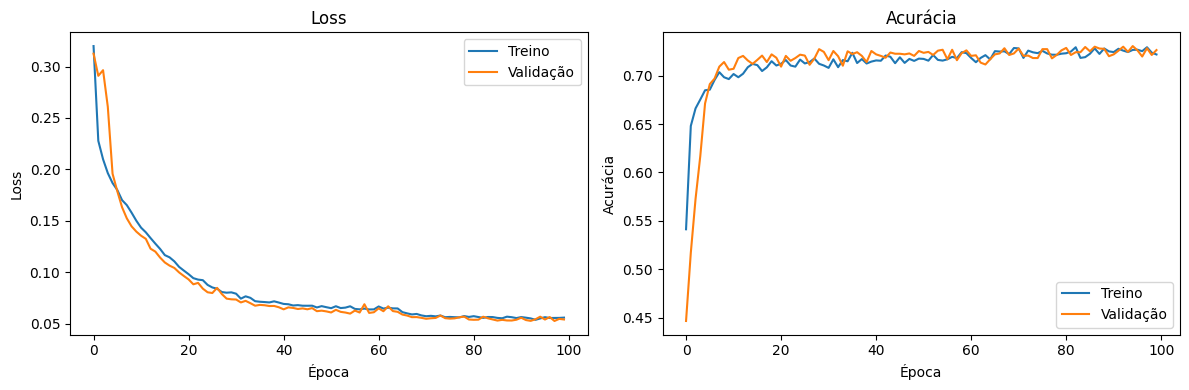

In [43]:
history_dict = history.history

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Treino')
plt.plot(history_dict['val_loss'], label='Validação')
plt.title('Loss')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_dict['accuracy'], label='Treino')
plt.plot(history_dict['val_accuracy'], label='Validação')
plt.title('Acurácia')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()

plt.tight_layout()
plt.show()

              precision    recall  f1-score   support

        drum       0.50      0.98      0.66       840
      guitar       0.99      0.99      0.99       840
       piano       0.99      0.99      0.99       635
      violin       0.43      0.02      0.04       840

    accuracy                           0.73      3155
   macro avg       0.73      0.74      0.67      3155
weighted avg       0.71      0.73      0.65      3155

Confusion matrix:
[[821   0   1  18]
 [  4 834   2   0]
 [  0   5 627   3]
 [822   1   1  16]]


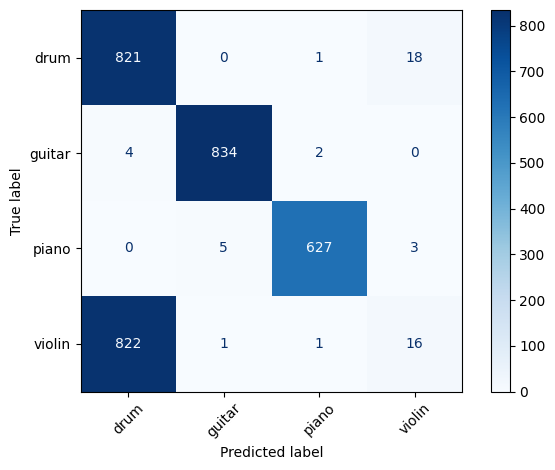

In [46]:
y_pred_probs = model.predict(X_val, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = y_val  

print(classification_report(
    y_true, 
    y_pred, 
    target_names=label_encoder.classes_  # usa as classes corretas
))

cm = confusion_matrix(y_true, y_pred)
print('Confusion matrix:')
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(xticks_rotation=45, cmap='Blues')
plt.tight_layout()
plt.show()

In [59]:
def load_filtered_data(csv_path):
    df = pd.read_csv(csv_path)
    df = df[df['class'].isin(['drum', 'violin'])].copy()

    df['features'] = df['features'].apply(ast.literal_eval)
    X = np.vstack(df['features'].values).astype(np.float32)

    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(df['class'].values)

    return X, y, label_encoder

X_dv, y_dv, label_encoder_dv = load_filtered_data(TRAINING_DATASET_TRAIN_METADATA)

X_train_dv, X_val_dv, y_train_dv, y_val_dv = train_test_split(
    X_dv, y_dv,
    test_size=0.2,
    random_state=42,
    stratify=y_dv
)

In [ ]:
def build_binary_dense_model(input_shape):
    inputs = layers.Input(shape=input_shape)

    x = layers.BatchNormalization()(inputs)

    x = layers.Dense(512, activation='swish', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)

    x = layers.Dense(256, activation='swish', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(128, activation='swish', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

In [71]:
model_dv = build_binary_dense_model(
    input_shape=ds_shape,
)

callbacks_dv = [
    EarlyStopping(patience=15, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.5, patience=10, verbose=1)
]

history_dv = model_dv.fit(
    X_train_dv, y_train_dv,
    validation_data=(X_val_dv, y_val_dv),
    batch_size=256,
    epochs=150,
    # callbacks=callbacks_dv
)

Epoch 1/150
27/27 ━━━━━━━━━━━━━━━━━━━━ 19s 236ms/step - accuracy: 0.4980 - loss: 5.2158 - val_accuracy: 0.5060 - val_loss: 0.8308
Epoch 2/150
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4990 - loss: 4.4237 - val_accuracy: 0.4982 - val_loss: 0.9159
Epoch 3/150
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4947 - loss: 4.0650 - val_accuracy: 0.4946 - val_loss: 0.8705
Epoch 4/150
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4922 - loss: 3.8712 - val_accuracy: 0.5024 - val_loss: 2.8311
Epoch 5/150
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4908 - loss: 3.6839 - val_accuracy: 0.4929 - val_loss: 0.8660
Epoch 6/150
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4954 - loss: 3.4879 - val_accuracy: 0.4768 - val_loss: 0.8680
Epoch 7/150
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4983 - loss: 3.5735 - val_accuracy: 0.4911 - val_loss: 0.9331
Epoch 8/150
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5050 - loss: 3.3868 - val_accuracy: 0.4976 

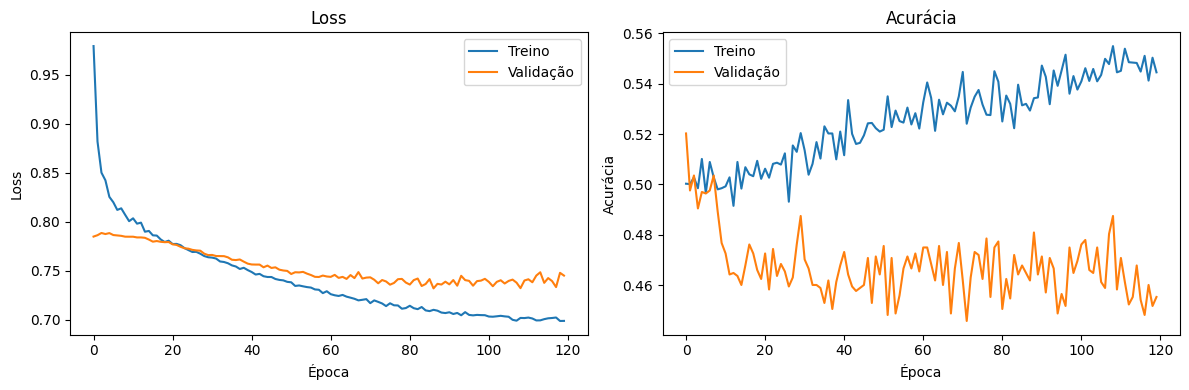

In [53]:
history_dict_dv = history_dv.history

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_dict_dv['loss'], label='Treino')
plt.plot(history_dict_dv['val_loss'], label='Validação')
plt.title('Loss')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_dict_dv['accuracy'], label='Treino')
plt.plot(history_dict_dv['val_accuracy'], label='Validação')
plt.title('Acurácia')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()

plt.tight_layout()
plt.show()

              precision    recall  f1-score   support

        drum       0.47      0.60      0.53       840
      violin       0.44      0.31      0.36       840

    accuracy                           0.46      1680
   macro avg       0.45      0.46      0.44      1680
weighted avg       0.45      0.46      0.44      1680

Confusion matrix (drum vs violin):
[[507 333]
 [582 258]]


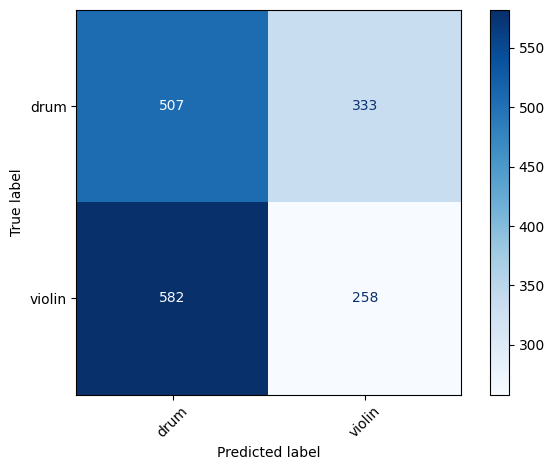

In [54]:
y_pred_probs_dv = model_dv.predict(X_val_dv, verbose=0)
y_pred_dv = (y_pred_probs_dv > 0.5).astype(int).flatten()
y_true_dv = y_val_dv

print(classification_report(
    y_true_dv, 
    y_pred_dv, 
    target_names=label_encoder_dv.classes_
))

cm_dv = confusion_matrix(y_true_dv, y_pred_dv)
print('Confusion matrix (drum vs violin):')
print(cm_dv)

disp_dv = ConfusionMatrixDisplay(confusion_matrix=cm_dv, display_labels=label_encoder_dv.classes_)
disp_dv.plot(xticks_rotation=45, cmap='Blues')
plt.tight_layout()
plt.show()


In [ ]:
pca_dv = PCA(n_components=2)
X_pca_dv = pca_dv.fit_transform(X_dv)

plt.scatter(X_pca_dv[:, 0], X_pca_dv[:, 1], c=y_dv, cmap='coolwarm', alpha=0.6)
plt.title("PCA: drum vs violin")
plt.show()



In [66]:
def predict_final_batch(X, model, model_dv, label_encoder, label_encoder_dv):
    """
    Predição refinada: usa model principal + model_dv para drum/violin.
    Retorna array (N, num_classes) com distribuições softmax finais.
    """
    probs_main = model.predict(X, verbose=0)  # shape (N, num_classes)
    preds_main_idx = np.argmax(probs_main, axis=1)
    preds_main_name = label_encoder.inverse_transform(preds_main_idx)

    # Índices das classes 'drum' e 'violin' no modelo principal
    idx_drum = np.where(label_encoder.classes_ == "drum")[0][0]
    idx_violin = np.where(label_encoder.classes_ == "violin")[0][0]

    # Identifica quais amostras precisam de refinamento
    mask_refine = np.isin(preds_main_name, label_encoder_dv.classes_)
    X_refine = X[mask_refine]

    if len(X_refine) > 0:
        probs_violin = model_dv.predict(X_refine, verbose=0).flatten()  # sigmoid: violin
        probs_drum = 1.0 - probs_violin

        probs_main_refined = probs_main.copy()

        for i, idx in enumerate(np.where(mask_refine)[0]):
            probs_main_refined[idx, idx_drum] = probs_drum[i]
            probs_main_refined[idx, idx_violin] = probs_violin[i]

            # Renormaliza a distribuição (softmax-style)
            probs_main_refined[idx] /= probs_main_refined[idx].sum()

        return probs_main_refined

    return probs_main


              precision    recall  f1-score   support

        drum       0.53      0.30      0.38       840
      guitar       0.99      0.99      0.99       840
       piano       0.99      0.99      0.99       635
      violin       0.51      0.73      0.60       840

    accuracy                           0.74      3155
   macro avg       0.76      0.75      0.74      3155
weighted avg       0.74      0.74      0.73      3155

Confusion matrix (com refinamento drum/violin):
[[251   0   1 588]
 [  0 834   2   4]
 [  0   5 627   3]
 [222   1   1 616]]


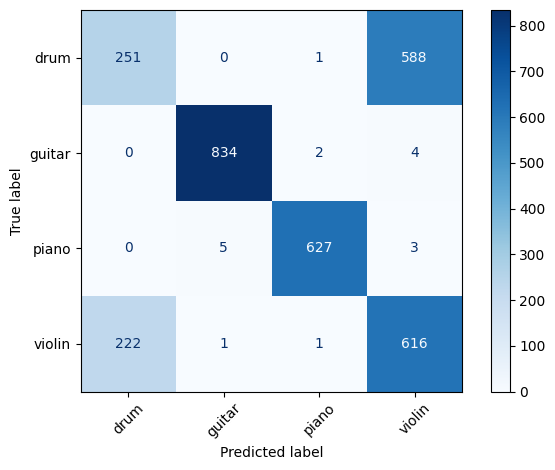

In [67]:
# 🔹 Fazer predições usando a função refinada
y_pred_probs_final = predict_final_batch(
    X_val,
    model,
    model_dv,
    label_encoder,
    label_encoder_dv
)

# 🔹 Inferir a classe com maior probabilidade
y_pred_final = np.argmax(y_pred_probs_final, axis=1)
y_true_final = y_val

# 🔹 Relatório de classificação
print(classification_report(
    y_true_final, 
    y_pred_final, 
    target_names=label_encoder.classes_
))

# 🔹 Matriz de confusão
cm_final = confusion_matrix(y_true_final, y_pred_final)
print('Confusion matrix (com refinamento drum/violin):')
print(cm_final)

disp_final = ConfusionMatrixDisplay(confusion_matrix=cm_final, display_labels=label_encoder.classes_)
disp_final.plot(xticks_rotation=45, cmap='Blues')
plt.tight_layout()
plt.show()
